In [117]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from cnn_utils import *
import collections
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

%matplotlib inline
np.random.seed(1)

In [103]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

In [104]:
to_tensor = transforms.ToTensor()

X_train = torch.zeros(X_train_orig.shape[0],
                      X_train_orig.shape[3],
                      X_train_orig.shape[1],
                      X_train_orig.shape[2])
for i in range(X_train.shape[0]):
    X_train[i] = to_tensor(X_train_orig[i])

X_test = torch.zeros(X_test_orig.shape[0],
                     X_test_orig.shape[3],
                     X_test_orig.shape[1],
                     X_test_orig.shape[2])
for i in range(X_test.shape[0]):
    X_test[i] = to_tensor(X_test_orig[i])

In [105]:
Y_train = torch.from_numpy(Y_train_orig).permute(1, 0)

Y_test = torch.from_numpy(Y_test_orig).permute(1, 0)

In [106]:
imgs = torch.stack([img_t for img_t in X_train], dim=3)

imgs.view(3, -1).mean(dim=1)
# 0.7630, 0.7105, 0.6634
imgs.view(3, -1).std(dim=1)
# 0.1538, 0.1998, 0.2221

tensor([0.1538, 0.1998, 0.2221])

In [107]:
normalize = transforms.Normalize((0.7630, 0.7105, 0.6634), (0.1538, 0.1998, 0.2221))

In [108]:
X_train = normalize(X_train)

X_test = normalize(X_test)

In [111]:
data = [(X_train[i], Y_train.squeeze()[i])
       for i in range(X_train.shape[0])]

In [112]:
data_val = [(X_test[i], Y_test.squeeze()[i])
       for i in range(X_test.shape[0])]

In [164]:
class Net(nn.Module):
    def __init__(self, n_chans1=16):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.fc1 = nn.Linear(n_chans1 // 2 * 8 * 8, 32)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(32, 6)
        
    def forward(self, x):
        out = F.max_pool2d(self.act1(self.conv1(x)), 4)
        out = F.max_pool2d(self.act2(self.conv2(out)), 2)
        out = out.view(-1, self.n_chans1 // 2 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [165]:
def training_loop(n_epochs, optimizer, model, loss_fn,
                 train_loader, val_loader):
    L_train = []
    L_val = []
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs_train, labels_train in train_loader:
            imgs_train = imgs_train.to(device=device)
            labels_train = labels_train.to(device=device)
            outputs = model(imgs_train)
            loss = loss_fn(outputs, labels_train)
            
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                         for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            L_train.append(loss_train / len(train_loader))
            
            with torch.no_grad():
                loss_val = 0.0
                for imgs_val, labels_val in val_loader:
                    imgs_val = imgs_val.to(device=device)
                    labels_val = labels_val.to(device=device)
                    outputs = model(imgs_val)
                    loss = loss_fn(outputs, labels_val)
                    
                    l2_lambda = 0.001
                    l2_norm = sum(p.pow(2.0).sum()
                                 for p in model.parameters())
                    loss = loss + l2_lambda * l2_norm
                    loss_val += loss.item()
                L_val.append(loss_val / len(val_loader))
                print('{} Epoch {}, Training loss {}, Validating loss {}'.format(
                     datetime.datetime.now(), epoch,
                     loss_train / len(train_loader),
                     loss_val / len(val_loader)))
    return L_train, L_val

In [166]:
device = (torch.device('cuda') if torch.cuda.is_available()
         else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [173]:
train_loader = torch.utils.data.DataLoader(data, batch_size=64,
                                          shuffle=True)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=8,
                                        shuffle=True)
model = Net().to(device=device)
model.train()
optimizer = optim.Adam(model.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss()

L_train, L_val = training_loop(n_epochs=700, 
              optimizer=optimizer,
              model=model, 
              loss_fn=loss_fn,
              train_loader=train_loader,
              val_loader=val_loader,
              )

2023-08-07 00:23:31.905182 Epoch 1, Training loss 1.8110463619232178, Validating loss 1.8097485939661662
2023-08-07 00:23:32.579334 Epoch 10, Training loss 1.700296451063717, Validating loss 1.6937270164489746
2023-08-07 00:23:33.399519 Epoch 20, Training loss 1.235938871608061, Validating loss 1.2467288057009378
2023-08-07 00:23:34.146688 Epoch 30, Training loss 0.900868205463185, Validating loss 0.933434788386027
2023-08-07 00:23:34.900858 Epoch 40, Training loss 0.7326684734400581, Validating loss 0.7800907870133718
2023-08-07 00:23:35.649581 Epoch 50, Training loss 0.620911089813008, Validating loss 0.6671832819779714
2023-08-07 00:23:36.421756 Epoch 60, Training loss 0.5358743054025313, Validating loss 0.5953455964724222
2023-08-07 00:23:37.181474 Epoch 70, Training loss 0.4758288386990042, Validating loss 0.5488920410474142
2023-08-07 00:23:37.951189 Epoch 80, Training loss 0.4281097475220175, Validating loss 0.5212363004684448
2023-08-07 00:23:38.720363 Epoch 90, Training loss 0

In [174]:
train_loader = torch.utils.data.DataLoader(data, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 1.00
Accuracy val: 0.92


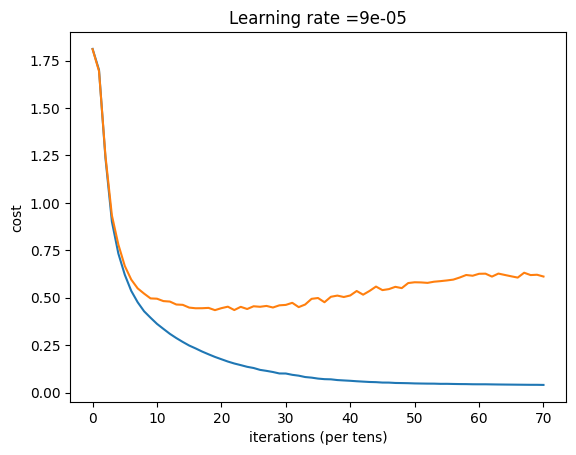

In [175]:
plt.plot(L_train)
plt.plot(L_val)
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(0.00009))
plt.show()